In [1]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import timedelta
import warnings 
warnings.filterwarnings('ignore')



In [2]:
data=pd.read_excel('../data/final_customer_data.xlsx')
data['DateTime'] = pd.to_datetime(data['DateTime'])
print(data.shape)
data.head()

(2090, 9)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User_id      2090 non-null   int64         
 1   Session_id   2090 non-null   object        
 2   DateTime     2090 non-null   datetime64[ns]
 3   Category     2090 non-null   object        
 4   SubCategory  2090 non-null   object        
 5   Action       2090 non-null   object        
 6   Quantity     201 non-null    float64       
 7   Rate         201 non-null    float64       
 8   Total Price  201 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


In [14]:
data.shape

(2090, 9)

In [4]:
def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    # Final date in the data + 1 to create latest date
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # RFM feature creation
    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days, 
                                          transID: lambda x: len(x), 
                                          sales: lambda x: sum(x)})
    
    # Converting invoiceDate to int since this contains number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Renaming column names to Recency, Frequency and Monetary
    RFMScores.rename(columns={invoiceDate: 'Recency', 
                         transID: 'Frequency', 
                         sales: 'Monetary'}, inplace=True)
    
    return RFMScores.reset_index()

In [5]:
RFM = RFM_Features(df=data[data['Action']=='purchase'], customerID= "User_id", invoiceDate = "DateTime", transID= "Session_id", sales="Total Price")
print(RFM.shape)
RFM.head()

(167, 4)


,User_id,Recency,Frequency,Monetary
0,51448162784,10,2,21500.0
1,51455512201,64,1,10000.0
2,51462598385,7,2,550.0
3,51463622150,40,2,950.0
4,51465529647,10,2,15500.0


,Recency,Frequency,Monetary
count,167.000000,167.000000,167.000000
mean,112.263473,1.203593,11380.419162
std,91.085568,0.432685,20236.203462
min,1.000000,1.000000,150.000000
25%,41.500000,1.000000,1575.000000
50%,72.000000,1.000000,3000.000000
75%,164.000000,1.000000,10700.000000
max,345.000000,3.000000,160000.000000


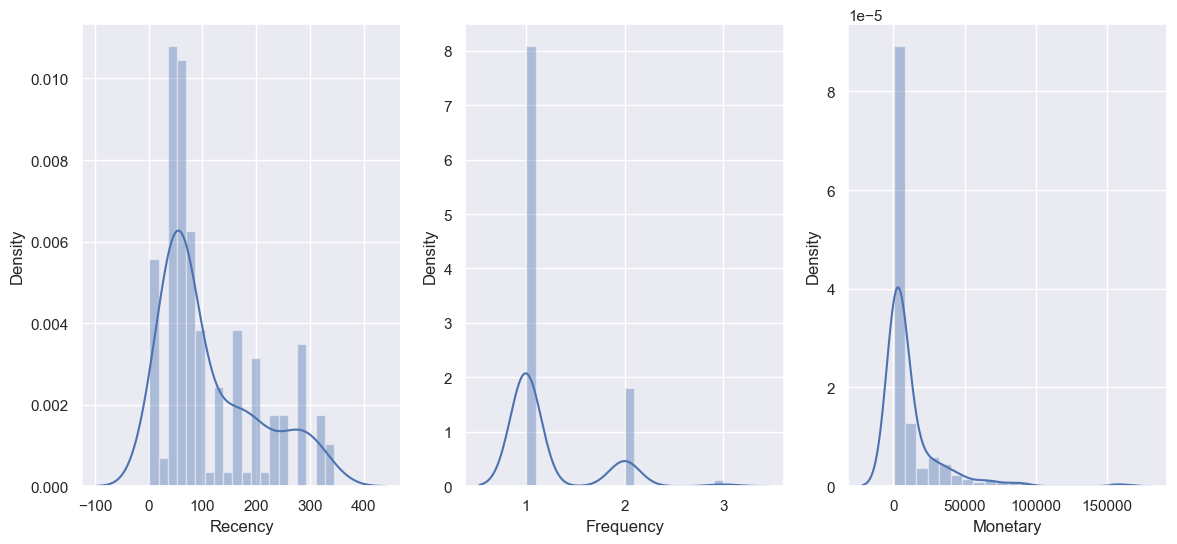

In [6]:
# Distribution of RFM features
display(RFM.drop('User_id',axis=1).describe())

# Distributions of Recency, Frequency, and Monetary features
fig, ax = plt.subplots(1,3, figsize=(14,6))
sns.distplot(RFM.Recency, bins=20, ax=ax[0])
sns.distplot(RFM['Frequency'], bins=20, ax=ax[1])
sns.distplot(RFM['Monetary'], bins=20, ax=ax[2])
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled=scaler.fit_transform(RFM)

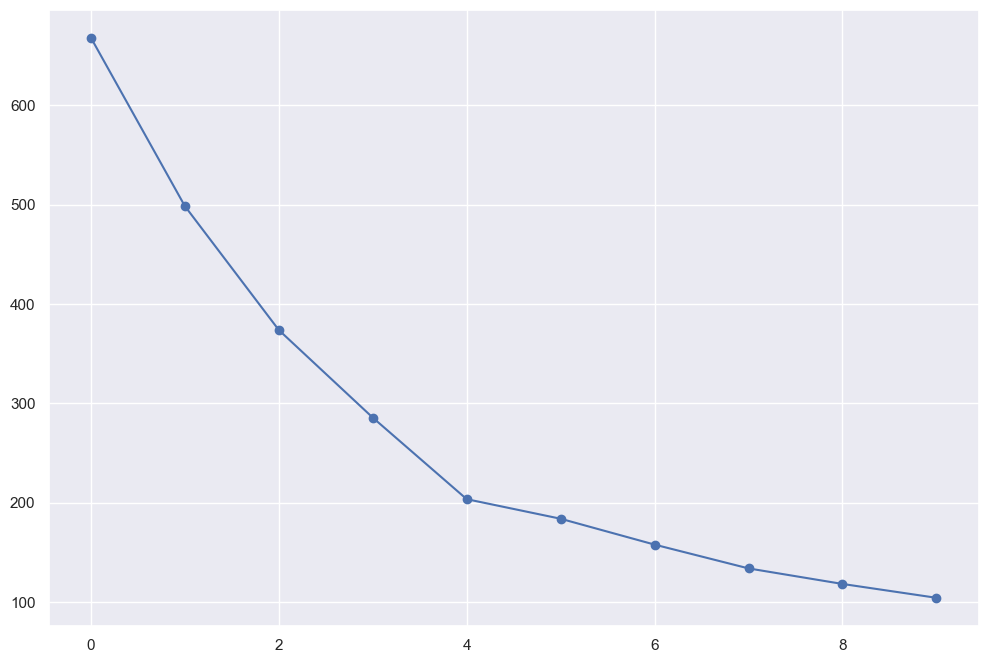

In [8]:
from sklearn.cluster import KMeans

inertia=[]

for i in np.arange(1,11):
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12,8))
plt.plot(inertia, marker="o")

In [9]:
kmeans=KMeans(n_clusters=4)
kmeans.fit(scaled)
RFM["Clusters"]=(kmeans.labels_+1)

In [10]:
RFM[:25]

,User_id,Recency,Frequency,Monetary,Clusters
0,51448162784,10,2,21500.0,3
1,51455512201,64,1,10000.0,2
2,51462598385,7,2,550.0,3
3,51463622150,40,2,950.0,3
4,51465529647,10,2,15500.0,3
5,51468519074,286,1,2500.0,1
6,51472029210,194,1,24400.0,1
7,51477448981,37,1,40000.0,4
8,51480378215,59,2,10500.0,3
9,51481443687,128,2,4250.0,3


In [11]:
final=RFM.groupby("Clusters")[["Recency","Frequency","Monetary"]].mean()
final

,Recency,Frequency,Monetary
Clusters,,,
1,250.666667,1.000000,6505.128205
2,73.419753,1.000000,4458.395062
3,62.933333,2.066667,10440.000000
4,66.882353,1.117647,57205.882353


In [12]:
RFM.shape

(167, 5)

In [13]:
data_with_RFM = pd.merge(data,RFM, on='User_id',how='left')
print(data_with_RFM.shape)
data_with_RFM.head()

(2090, 13)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,Clusters
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Specify the path where you want to save the Excel file
excel_file_path = '../data/file.xlsx'

In [16]:
data_with_RFM.to_excel(excel_file_path, index=False)